In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import os
import seaborn as sns
import random 
import scipy as sc
import statsmodels.api as sm
import scipy.stats as stats
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pygrib
import cfgrib
import glob

sns.set_theme(style="white")
sns.set_style("white")

random.seed(10)

In [10]:
class Data():
    def get_eps_data(experiments, inidate='2022-02-16'):
        """
        Function to load comlete data of simulations on surface level since
        xr has a bug that prevents using
        this as a simpler solution

        Input:
        ------
        experiments: list of strings, list of experiments to import,
                e.g. ['pi', 'curr', 'incr']

        Output:
        -------
        eps: list of xarrays, data and metadata of operational forecasts,
        each list entry is one experiment
        """

        directory = {'pi': '/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/EXP/pi/EU025/sfc/',
                    'curr': '/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/ENS/EU025/sfc/',
                    'incr': '/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/EXP/incr/EU025/sfc/'}

        eps = {}
        for experiment in experiments:
            exp_eps = []
            for c, cont in enumerate(['cf', 'pf']):
                for files in glob.glob(directory[experiment]
                                        + cont + '/*'
                                        + inidate + '*.nc'):
                    print(files)
                    data = xr.open_dataset(files)
                    exp_eps.append(Data.preproc_ds(data.get(['fg10', 'msl',
                                                                'u10', 'v10',
                                                                'u100', 'v100','mxcape6'])))

            eps[experiment] = xr.concat(exp_eps, dim='number').squeeze()

        return eps
    

    def preproc_ds(ds):
        """
        Main pre-processing function
        Writtten by Nick Leach.

        Input:
        ------

        Output:
        -------
        """

        # accumulated variables & scaling factors
        accumulated_vars = {'tp': 60 * 60 * 24 * 1e3,
                            'ttr': 1,
                            'tsr': 1,
                            'str': 1,
                            'ssr': 1,
                            'e': 1}
        accumulated_var_newunits = {'tp': 'mm day$^{-1}$',
                                    'ttr': 'W m$^{-2}$',
                                    'tsr': 'W m$^{-2}$',
                                    'str': 'W m$^{-2}$',
                                    'ssr': 'W m$^{-2}$',
                                    'e': 'm s$^{-1}$'}
        ds = ds.copy().squeeze()
        # set up aux data
        inidate = pd.to_datetime(ds.time[0].values)
        # expand dimensions to include
        if not 'hDate' in ds:
            ds = ds.expand_dims({'inidate': [inidate]}).copy()

        if not 'number' in ds:
            ds = ds.expand_dims({'number': [0]}).copy()

        # put time dimension at front
        ds = ds.transpose('time', ...)
        ds = ds.copy(deep=True)

        # convert accumulated variables into instantaneous
        for var, sf in accumulated_vars.items():
            if var in ds.keys():
                ds[var].loc[dict(time=ds.time[1:])] = Data.accum2rate(ds[var]) * sf
                # set first value to equal zero,
                # should be zero but isn't always
                ds[var].loc[dict(time=ds.time[0])] = 0
                ds[var].attrs['units'] = accumulated_var_newunits[var]
        return ds

Is it possibly to see the CAPE evolution thru time? Like, choose a date of initialization, run the three experiments parallel to each other, and see how they differ?
I mean there are still 51 ensemble members for each init date and each 

In [11]:
experiments = ['pi','curr','incr']
da = {}

for e in experiments:
    da[e] = Data.get_eps_data([e],inidate='2022-02-10')

da

/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/EXP/pi/EU025/sfc/cf/b2nq_2022-02-10.nc
/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/EXP/pi/EU025/sfc/pf/b2nq_2022-02-10.nc
/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/ENS/EU025/sfc/cf/1_2022-02-10.nc
/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/ENS/EU025/sfc/pf/1_2022-02-10.nc
/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/EXP/incr/EU025/sfc/cf/b2nr_2022-02-10.nc
/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/EXP/incr/EU025/sfc/pf/b2nr_2022-02-10.nc


{'pi': {'pi': <xarray.Dataset>
  Dimensions:    (number: 51, time: 81, latitude: 163, longitude: 289)
  Coordinates:
    * number     (number) int64 0 1 2 3 4 5 6 7 8 9 ... 42 43 44 45 46 47 48 49 50
      inidate    datetime64[ns] 2022-02-10
    * longitude  (longitude) float32 -27.0 -26.75 -26.5 -26.25 ... 44.5 44.75 45.0
    * latitude   (latitude) float32 73.5 73.25 73.0 72.75 ... 33.5 33.25 33.0
    * time       (time) datetime64[ns] 2022-02-10 ... 2022-02-20
  Data variables:
      fg10       (time, number, latitude, longitude) float32 0.0 0.0 ... 9.09
      msl        (time, number, latitude, longitude) float32 1.007e+05 ... 1.01...
      u10        (time, number, latitude, longitude) float32 0.7009 ... 3.699
      v10        (time, number, latitude, longitude) float32 -1.216 ... -0.4414
      u100       (time, number, latitude, longitude) float32 0.8544 ... 6.825
      v100       (time, number, latitude, longitude) float32 -1.18 ... -2.607
      mxcape6    (time, number, latitu

In [34]:
cape={}
for e in experiments:
    cape[e] = da[e][e].mxcape6.sel(time='2022-02-16').sortby(da[e][e].mxcape6.sel(time='2022-02-16').quantile(0.95,dim=['latitude','longitude','time']),ascending=False)[:10].mean(dim='number').max(dim='time')

/home/l/luol/nobackups/miniconda3/envs/storm_dudley/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1662: UserWarning: The following kwargs were not used by contour: 'level'
  result = super().contourf(*args, **kwargs)


/home/l/luol/nobackups/miniconda3/envs/storm_dudley/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


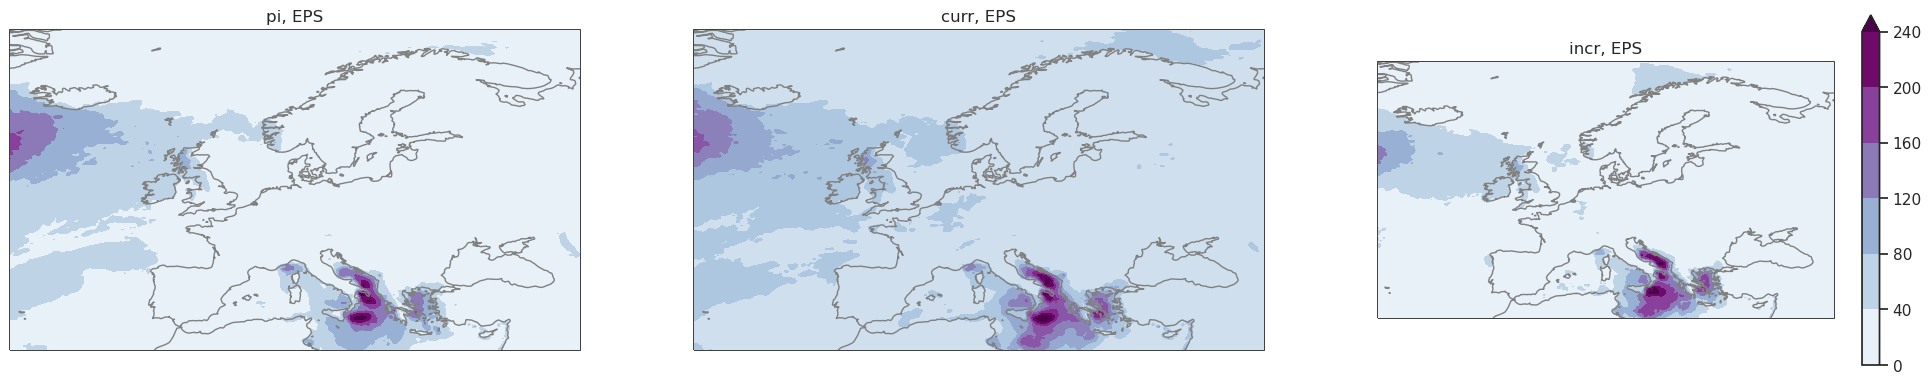

In [39]:
uk = [-11, 5, 48, 60]
level = list(range(0,40,3))
fig = plt.figure(1, figsize=(25, 10))
cape_level=np.linspace(0,240,11)

projection = ccrs.PlateCarree()

lat = da['pi']['pi'].sel(time='2022-02-16 12').latitude.values
lon = da['pi']['pi'].sel(time='2022-02-16 12').longitude.values

for num, e in enumerate(experiments):
    ax = plt.subplot(2,3, num+1, projection = projection)
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), color = 'grey', zorder = 14)
    
    

    

    cf = ax.contourf(lon, lat, cape[e],level=cape_level, cmap=plt.cm.BuPu,
                    transform=projection, zorder = 10, extend = 'max')
    
    
    ax.set_title(e+", EPS")

fig.colorbar(cf)


Okay, my intention of looking at this is to figure out latent heat release, but apparently LH release is very much unrelated to CAPE. Instead, this can only show atmosphereic instability. However, I don't think I can find anything interesting here. Atmosphere seems to be wierdly slightly more stable in incr than pi. Very unexpecteddddd and hard to explain.

In [17]:
for e in experiments:
    cape[e] = da[e][e].mxcape6

